In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from Bio.Seq import Seq
from prody import *
from scipy.spatial import distance_matrix
from annotate import Annotate
import ablang

In [2]:
# импортируем датасет

df = pd.read_table('data/20230314_0502373_summary.tsv')

# оставляем только protein и peptide в качестве antigen_type

df = df[df['antigen_chain'].apply(lambda x: type(x) == str)] # случаи когда тип антигена не определен
df = df[df['Lchain'].apply(lambda x: type(x) == str)] # случаи когда id цепи антитела не определены
df = df[df['Hchain'].apply(lambda x: type(x) == str)] # случаи когда id цепи антитела не определены


def func(s):
    for si in s.split(' | '):
        if si != 'peptide' and si != 'protein':
            return False
    return True

df = df[df['antigen_type'].apply(func)]

# также в датасете scfv. Такое тоже убираем. Софт для аннотации который я использую не справляется с таким все равно.

df = df[df.scfv == False]

In [3]:
def get_y(seq, parseq, scheme='chothia'):
    """
    Делает много чего, но в основном нумерует последовательность антитела seq.
    И возвращает "отнумерованное" антитело, паратоп, regions и y

    описание regions:
        regions[i] == '0' => i-ая аминокислота в FR1
        regions[i] == '1' => i-ая аминокислота в CDR1
        regions[i] == '2' => i-ая аминокислота в FR2
        regions[i] == '3' => i-ая аминокислота в CDR2
        regions[i] == '4' => i-ая аминокислота в FR3
        regions[i] == '5' => i-ая аминокислота в CDR3
        regions[i] == '6' => i-ая аминокислота в FR4

    описание y:
       y[i] == 1 если паратоп есть в regions[i]

    """
    assert len(seq) == len(parseq)
    num = Annotate(seq, scheme).retrieve()
    if num is None:
        raise TypeError
    skipped_aacids = int(list(num[1])[0][1:]) - 1 # сколько аминокислот отсутствуют с С конца
    seq = ''.join(num[0][i] for i in num[0]) # оставляем только V-домен
    parseq = parseq[:len(seq)]
    is_paratope = (np.array(list(parseq)) == '+')
    if sum(is_paratope[len(seq):]) > 0: # отбрасываем такое антитело тк оно содержит паратоп в С-домене.
        print('-------C-domain-alert-------')
        raise TypeError
    regions = np.zeros(len(seq), dtype=int)
    y = list('0000000')
    start = 0
    for i, k in enumerate(num[0]):
        end = start + len(num[0][k])
        regions[start: end] = i
        if sum(is_paratope[start:end]) > 0:
            y[i] = '1'
        start = end
    regions = ''.join(map(str, regions))
    seq = '*'*skipped_aacids + seq # добавим слева "*" обозначающие отсутствующие аминокислоты
    parseq = '-'*skipped_aacids + parseq # добавим слева "-" чтобы выравнять длины цепей
    regions = '0'*skipped_aacids + regions
    return seq, parseq, regions, ''.join(y)

# Пример 

seq = 'SPGERATLSCRASQSVSDAYLAWYQQKPGQAPRLLIYDASSRATGVPARFSGSGSGTDFTLTISSLEPEDFAVYYCHQYIQLHSFTFGQGTKVEIKRTVAAPSVFIFPPSDEQLKSGTASVVCLLNNFYPREAKVQWKVDNALQSGNSQESVTEQDSKDSTYSLSSTLTLSKADYEKHKVYACEVTHQGLSSPVTKSFNR'
par = '----------------++-+----------------++----------------------------------------++-+----------------------------------------------------------------------------------------------------------------------'

get_y(seq, par, scheme='chothia')

('*************SPGERATLSCRASQSVSDAYLAWYQQKPGQAPRLLIYDASSRATGVPARFSGSGSGTDFTLTISSLEPEDFAVYYCHQYIQLHSFTFGQGTKVEIKRTV',
 '-----------------------------++-+----------------++----------------------------------------++-+-----------------',
 '0000000000000000000000011111111111122222222222222233333334444444444444444444444444444444455555555556666666666666',
 '0111010')

In [4]:
# некоторые функции для того, чтобы парсить pdb файлики

def in_order(a: np.ndarray):
    """
    Проверяет, что массив отсортирован в возрастающем порядке
    """
    return np.all(a[:-1] <= a[1:])


def get_paratope(ab: AtomGroup, ag: AtomGroup, dist=4) -> np.ndarray:
    """
    ab: AtomGroup антитела
    ag: AtomGroup антигена

    Парсит и возвращает индексы аминокислот в паратопе.
    Считаем, что аминокислота принадлежит паратопу если 
    у этой аминокислоты есть атом расстояние от которого
    до любого из атомов антигена меньше dist. 
    По дефолту dist=4 ангстрема 
    (так паратоп получался не слишком большой и не слишком маленький).
    """
    paratope_atom_ids = []
    dm = distance_matrix(ab.getCoords(), ag.getCoords())
    for i in range(dm.shape[0]):
        for j in range(dm.shape[1]):
            if dm[i, j] < dist:
                paratope_atom_ids.append(i)
    ab_res_inds = ab.select('ca').getResindices()
    assert in_order(ab_res_inds)
    paratope = ab.getResindices()[paratope_atom_ids] - ab_res_inds[0]
    return np.unique(paratope)


def get_paratope_seq(ab, ag, dist=4):
    """
    Применяет get_paratope(ab, ag, dist=4) и возвращает последовательнось 
    антитела и последовательность паратопа: "+" - паратоп; "-" - не паратоп
    """
    ab_seq = ab.select('ca').getSequence()
    par_seq = np.array(['-' for _ in range(len(ab_seq))])
    par = get_paratope(ab, ag, dist=dist)
    flag = True
    if len(par) == 0:
        flag = False
    else:
        try:
            # иногда бывает IndexError из-за ошибок в pdb файлике
            par_seq[par] = '+'
        except IndexError:
            print('-----failed-----get_paratope_seq')
            flag = False
    return ab_seq, ''.join(par_seq), flag


def get_dist_matrix(chain_atoms: AtomGroup, chain_len: int) -> np.ndarray:
    coodrs = chain_atoms.select('ca').getCoords()[:chain_len, :]
    return distance_matrix(coodrs, coodrs)

def append_to_dist_dict(dist_dict: dict, dist_matr: np.ndarray, pdb_id: str, chain_id: str) -> dict:
    """
    Добавляет матрицу смежности к dist_dict
    """
    if pdb_id not in dist_dict:
        dist_dict[pdb_id] = dict()
    dist_dict[pdb_id][chain_id] = dist_matr
    return dist_dict


In [ ]:
# Применяем все выше написанное и получаем
# Заняло примерно 3 часа

d = {
    'pdb': [],
    'L_chain': [],
    'H_chain': [],
    'AG_chain': [],
    'L_sequence_missing': [],
    'H_sequence_missing': [],
    'L_paratope': [],
    'H_paratope': [],
    'L_domain': [],
    'H_domain': [],
    'L_y': [],
    'H_y': [],
}
dist_dict = dict()

for i, row in tqdm(df.iterrows(), total=len(df)):
    l = row.Lchain
    h = row.Hchain
    ag = row.antigen_chain
    for a in ag.split(' | '):
        atoms = parseMMCIF('pdb/{}.cif.gz'.format(row.pdb))
        ag_atoms = atoms.select('chain {} protein'.format(a))
        lc_atoms = atoms.select('chain {} protein'.format(l))
        hc_atoms = atoms.select('chain {} protein'.format(h))
        if ag_atoms is None or lc_atoms is None or hc_atoms is None:
            # почему-то индексы цепей в pdb файлике и в датасете отличаются. 
            # Там бывает, что в датасете у легкой цепи антитела индекс 'L', 
            # а в pdb файлике у нее индекс 'LLL'. Я просто скипаю такие цепи. 
            # Если честно было лень разбираться. К тому же таких инцидентов 4-5 штук.
            print('-----failed-----parse-PDB')
            continue
        L_sequence, L_paratope, flag1 = get_paratope_seq(lc_atoms, ag_atoms)
        H_sequence, H_paratope, flag2 = get_paratope_seq(hc_atoms, ag_atoms)
        try:
            # иногда библиотека которую я использую для нумерования
            # антител не срабатывает по разным причинам (например, цепь из pdb файлика не полная)
            # тогда скипаем такое антитело
            L_sequence, L_paratope, L_domain, L_y = get_y(L_sequence, L_paratope)
            H_sequence, H_paratope, H_domain, H_y = get_y(H_sequence, H_paratope)
            assert len(L_sequence) == len(L_paratope) and len(L_sequence) == len(L_domain)
            assert len(H_sequence) == len(H_paratope) and len(H_sequence) == len(H_domain)
        except TypeError:
            print('-----failed-----get_y')
            continue
        l_seq_len = len(L_sequence.strip('*'))
        l_dist_matr = get_dist_matrix(lc_atoms, l_seq_len)
        dist_dict = append_to_dist_dict(dist_dict, l_dist_matr, row.pdb, l)
        h_seq_len = len(H_sequence.strip('*'))
        h_dist_matr = get_dist_matrix(hc_atoms, h_seq_len)
        dist_dict = append_to_dist_dict(dist_dict, h_dist_matr, row.pdb, h)
        d['pdb'].append(row.pdb)
        d['L_chain'].append(l)
        d['H_chain'].append(h)
        d['AG_chain'].append(a)
        d['L_sequence_missing'].append(L_sequence)
        d['H_sequence_missing'].append(H_sequence)
        d['L_paratope'].append(L_paratope)
        d['H_paratope'].append(H_paratope)
        d['L_domain'].append(L_domain)
        d['H_domain'].append(H_domain)               
        d['L_y'].append(int(L_y, 2))
        d['H_y'].append(int(H_y, 2))

pd.DataFrame(d).to_csv('data/full_ds.csv', index=False)

with open('data/dist_dict.pickle', 'wb') as handle:
    pickle.dump(dist_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Восстановление последовательностей антител

In [18]:
df = pd.read_csv('data/full_ds.csv') 

Как можно заметить, в датасете присутствуют последовательности которые chothia расценила как неполные. Их можно дополнить. Будем использовать для этого AbLang. 

<Axes: >

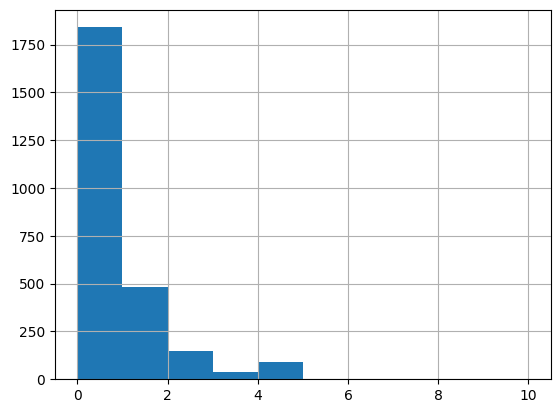

In [84]:
# распределение по количеству отсутствующих аминокислот в начале цепи для легких цепей

df.L_sequence.apply(lambda x: len(x) - len(x.strip('*'))).hist(bins=10, range=[0, 10])

<Axes: >

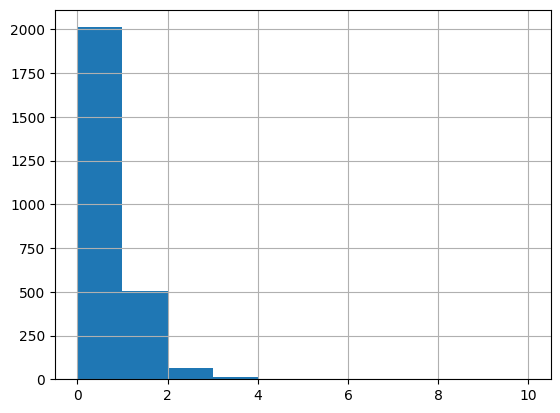

In [83]:
# распределение по количеству отсутствующих аминокислот в начале цепи для тяжелых цепей

df.H_sequence.apply(lambda x: len(x) - len(x.strip('*'))).hist(bins=10, range=[0, 10])

Импортируем модели восстанавливаем для тяжелых и легких цепей

In [89]:
heavy = ablang.pretrained('heavy')
light = ablang.pretrained('light')

In [90]:
# заняло примерно 7 минут на cpu

restored_heavy_chains = []
restored_light_chains = []

for i, row in tqdm(df.iterrows(), total=len(df)):
    seq_h = row.H_sequence
    seq_l = row.L_sequence
    if len(seq_h) - len(seq_h.strip('*')) > 0:
        seq_h = heavy(seq_h, mode='restore')[0]
    restored_heavy_chains.append(seq_h)
    if len(seq_l) - len(seq_l.strip('*')) > 0:
        seq_l = light(seq_l, mode='restore')[0]
    restored_light_chains.append(seq_l)

100%|██████████| 2602/2602 [05:55<00:00,  7.33it/s]


In [97]:
df['H_sequence'] = restored_heavy_chains
df['L_sequence'] = restored_light_chains

In [ ]:
df.to_csv('data/full_ds.csv', index=False)

Кластеризация в файлике clustering.ipynb